In [1]:
# NUMPY
import numpy as np
np.random.seed(3946)
# MATPLOTLIB
import matplotlib.pyplot as plt
plt.style.context('dark_background')
%matplotlib inline 
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (16, 6)}
plt.rcParams.update(params)

# SEABORN 
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

# SKLEARN 
from sklearn.metrics import pairwise_distances

# WARNINGS
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# TIME
from time import time 

# PATH 
import sys
path_files = '/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/'
sys.path.insert(0, path_files) 

# POT
import ot
from ot import sinkhorn, emd

# GREENKHORN 
from ot.bregman import greenkhorn

# SCREENKHORN
from screenkhorn.screenkhorn import Screenkhorn
from screenkhorn.path_regularization import path_regularization_with_restricted_Sinkhorn, path_regularization


## Data generation

In [2]:
n_1 = 200# nb samples
n_2 = 100
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n_1, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n_2, mu_t, cov_t)

a = np.ones((n_1,)) / n_1
b = np.ones((n_2,)) / n_2  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()
reg = 0.7

K = np.exp(-M/reg)

In [3]:
# plt.scatter(xs[:,0], xs[:,1], marker='^', c='m')
# plt.scatter(xt[:,0], xt[:,1], marker='o', c='g');

## Sinkhorn 

In [4]:
tic = time()
P_sink = sinkhorn(a, b, M, reg, log=True)
P_star = P_sink[0]
outputs_dict = P_sink[1]
exp_u_star = outputs_dict['u']
exp_v_star = outputs_dict['v']
time_sink = time() - tic
print("time of Sinkhorn algorithm is %s" %time_sink)

time of Sinkhorn algorithm is 0.003548860549926758


## Screenkhorn

### Restricted Sinkhorn algorithm

#### Bounds of $\varepsilon \in (\varepsilon_{\min}, \varepsilon_{\max})$

\begin{equation}
\label{varepsilon_min}
\varepsilon_{\min} = \min\bigg\{\min_{i}\sqrt{\frac{\mu_i}{\sum_{j}K_{ij}}}, \min_{j}\sqrt{\frac{\nu_j}{\sum_{i}K_{ij}}}\bigg\},
\end{equation}
and 
\begin{align}
	\label{varepsilon_max}
	\varepsilon_{\max} = \max\bigg\{\max_{i}\sqrt{\frac{\mu_i}{\sum_{j}K_{ij}}}, \max_{j}\sqrt{\frac{\nu_j}{\sum_{i}K_{ij}}}\bigg\}.
\end{align}

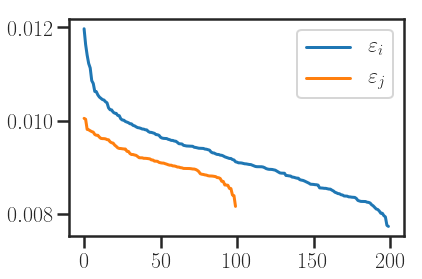

In [5]:
epsilon_tree_a = np.sqrt(a / K.sum(axis=1))
epsilon_tree_a_sort = np.sort(epsilon_tree_a)[::-1]
epsilon_tree_b = np.sqrt(b / K.T.sum(axis=1))
epsilon_tree_b_sort = np.sort(epsilon_tree_b)[::-1]
plt.plot(epsilon_tree_a_sort, label=r'$\varepsilon_i$')
plt.plot(epsilon_tree_b_sort, label=r'$\varepsilon_j$')
plt.legend();

#### Choice of epsilon

In [6]:
epsilon_tree_ab = np.sort(np.hstack([epsilon_tree_a, epsilon_tree_b]))[::-1]
epsilon_tree_ab_eps_1 = (max(epsilon_tree_ab) - min(epsilon_tree_ab))/2 + min(epsilon_tree_ab)
epsilon_tree_ab_eps_2 = (max(epsilon_tree_ab) - min(epsilon_tree_ab))/3 + min(epsilon_tree_ab)

epsilon_tree_ab_eps = np.array([epsilon_tree_ab_eps_2])

#### Initial points and a priori active sets

In [7]:
log_epsilons = np.log(epsilon_tree_ab_eps)
u0 = np.full(n_1, np.max(log_epsilons))
v0 = np.full(n_2, np.max(log_epsilons))

I_active = np.where(a >= np.mean(epsilon_tree_ab_eps)** 2 * K.sum(axis=1))[0].tolist()
J_active = np.where(b >= np.mean(epsilon_tree_ab_eps)** 2 * K.T.sum(axis=1))[0].tolist()

u0[I_active] = - 10 * np.mean(log_epsilons)
v0[J_active] = - 10 * np.mean(log_epsilons)

In [8]:
## Cardinals of I_test and J_test
len(I_active), len(J_active)

(99, 46)

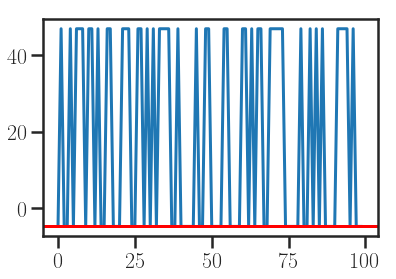

In [9]:
## Check the initial points
plt.plot(u0[:100]);
plt.axhline(y=np.max(log_epsilons), color='r');

#### Initialize Screenkhorn class

In [10]:
epsilon = epsilon_tree_ab_eps[0]
screenkhorn = Screenkhorn(a, b, M, reg, epsilon)

In [11]:
tic = time()
sinkhornlike = screenkhorn.restricted_sinkhorn(np.exp(u0), np.exp(v0), I_active, J_active, max_iter=100, tol=1e-9)
time_res_sink = time() - tic
print("time of restricted Sinkhorn algorithm is %s \n" %time_res_sink)
print("Ratio between restricted_sinkhorn and sinkhorn is % s" %(time_res_sink/time_sink))

time of restricted Sinkhorn algorithm is 0.005648136138916016 

Ratio between restricted_sinkhorn and sinkhorn is 1.591535102452133


In [12]:
u_sink_like = sinkhornlike["usc"]
v_sink_like = sinkhornlike["vsc"]

### Restricted Greenkhorn

In [13]:
tic = time()
greenlike = screenkhorn.restricted_greenkhorn(np.exp(u0), np.exp(v0), I_active, J_active, max_iter=1000, tol=1e-9)
time_res_green = time() - tic
print("time of restricted Greenkhorn algorithm is %s \n" %time_res_green)
print("Ratio between restricted_greenkhorn and sinkhorn is % s" %(time_res_green/time_sink))

time of restricted Greenkhorn algorithm is 0.053627729415893555 

Ratio between restricted_greenkhorn and sinkhorn is 15.111252939200538


In [14]:
u_green_like = greenlike["usc"]
v_green_like = greenlike["vsc"]
# P_green_like = greenlike["Psc"]

#### Figures

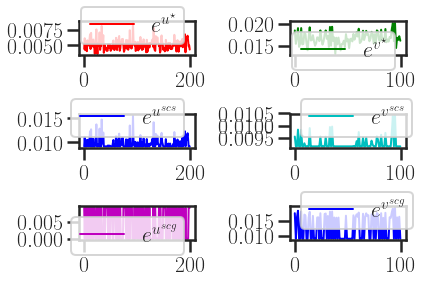

In [15]:
figure, axes= plt.subplots(nrows=3, ncols=2)

axes[0,0].plot(exp_u_star, linewidth=2, color='r', label=r'$e^{u^\star}$')
axes[1,0].plot(u_sink_like, linewidth=2, color='b', label=r'$e^{u^{scs}}$')
axes[2,0].plot(u_green_like, linewidth=2, color='m', label=r'$e^{u^{scg}}$')

axes[0,1].plot(exp_v_star, linewidth=2, color='g', label=r'$e^{v^\star}$')
axes[1,1].plot(v_sink_like, linewidth=2, color='c', label=r'$e^{v^{scs}}$')
axes[2,1].plot(v_green_like, linewidth=2, color='b', label=r'$e^{v^{scg}}$')

axes[0,0].legend()
axes[1,0].legend()
axes[2,0].legend()

axes[0,1].legend()
axes[1,1].legend()
axes[2,1].legend()

plt.subplots_adjust(hspace=.5)
plt.tight_layout()

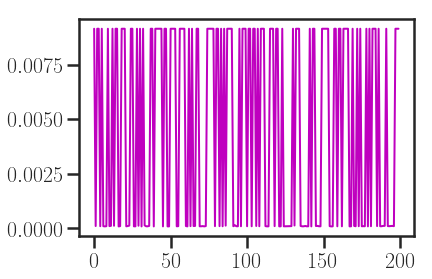

In [16]:
# plt.plot(exp_u_star, linewidth=2, color='r', label=r'$e^{u^\star}$')
# plt.plot(u_sink_like/1e23, linewidth=2, color='b', label=r'$e^{u^\star}$');
# plt.plot(u_green_like/1e23, linewidth=2, color='m', label=r'$e^{u^\star}$');

plt.plot(u_green_like, linewidth=2, color='m', label=r'$e^{u^\star}$');
# plt.plot(v_green_like, linewidth=2, color='m', label=r'$e^{u^\star}$');

## Comparison of marginals

In [17]:
(P_star @ np.ones(n_2)).sum()

1.0

In [18]:
(P_star.T @ np.ones(n_1)).sum()

1.0

In [19]:
P_sc_sink = np.diag(u_sink_like) @ K @ np.diag(v_sink_like)
P_sc_green = np.diag(u_green_like) @ K @ np.diag(v_green_like)

In [20]:
(P_sc_sink @ np.ones(n_2)).sum(), (P_sc_sink.T @ np.ones(n_1)).sum()

(1.075707536443674, 1.075707536443674)

In [21]:
(P_sc_green @ np.ones(n_2)).sum(), (P_sc_green.T @ np.ones(n_1)).sum()

(0.787047218153202, 0.787047218153202)

## PGD and restricted Sinkhorn

Time spending during restricted Skinkhorn is 0.04779505729675293


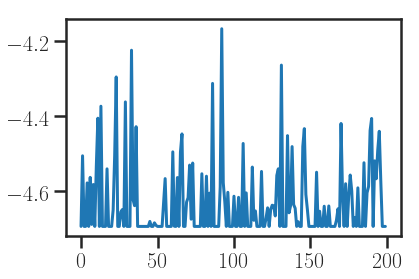

In [22]:
## PGD
## choice of solver, the 'acc_proj_grad' is the fastest.
# solver = 'proj_grad' 
# solver = 'block_acc_proj_grad' 
# solver = 'block_proj_grad'
solver = 'acc_proj_grad'

## params of solver
step_size_solver = None
backtracking_solver = False
max_iter_backtracking_solver = 30
max_iter_solver = 1000
tol_solver = 1e-9

tic = time()
u, v = path_regularization_with_restricted_Sinkhorn(a, b, M, reg, u0, v0, epsilon_tree_ab_eps,
                                                    solver=solver,
                                                    step_size_solver=step_size_solver,
                                                    backtracking_solver=backtracking_solver,
                                                    max_iter_backtracking_solver=max_iter_backtracking_solver,
                                                    max_iter_solver=max_iter_solver,
                                                    tol_solver=tol_solver)
time_path = time() - tic
time_path


# plt.plot(u0)
# plt.plot(v);
plt.plot(u);
# plt.plot(v);
# plt.plot(v0);

# screenkhorn = Screenkhorn(a, b, M, reg, 0.0095) #epsilon_tree_ab_eps[0])
# sol_eps = screenkhorn.projected_grad(u00, v00, I_test, J_test,
                                           # max_iter_backtracking=10,
                                           # step_size=10., max_iter=1000, tol=1e-8, verbose=False)

In [23]:
time_path, time_sink, time_path / time_sink 

(1.4537019729614258, 0.003548860549926758, 409.6249916022842)

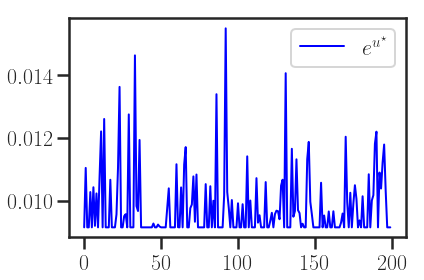

In [24]:
# plt.plot(exp_u_star, linewidth=2, color='r', label=r'$e^{u^\star}$')
plt.plot(np.exp(u), linewidth=2, color='b', label=r'$e^{u^\star}$')

# plt.plot(exp_v_star, linewidth=2, color='b', label=r'$e^{v^\star}$')
plt.legend()
plt.subplots_adjust(hspace=.5)
plt.tight_layout()


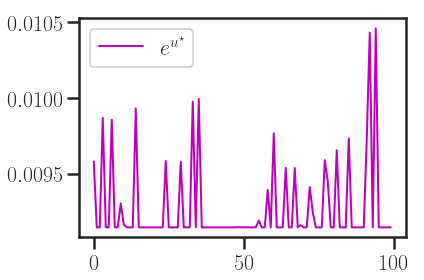

In [25]:
#plt.plot(exp_v_star, linewidth=2, color='g', label=r'$e^{u^\star}$')
plt.plot(np.exp(v), linewidth=2, color='m', label=r'$e^{u^\star}$')

# plt.plot(exp_v_star, linewidth=2, color='b', label=r'$e^{v^\star}$')
plt.legend()
plt.subplots_adjust(hspace=.5)
plt.tight_layout()

In [26]:
P_active = np.diag(np.exp(u)) @ K @ np.diag(np.exp(v))
P_active = np.diag(np.exp(u)) @ K @ np.diag(np.exp(v))

(P_star - P_active).max()

4.462485617668676e-06

In [27]:
(P_active @ np.ones(n_2)).sum(), (P_active.T @ np.ones(n_1)).sum()

(1.072857860530297, 1.072857860530297)

## Comparaison of active sets

In [28]:
I_like = np.where(u_sink_like > epsilon)[0].tolist()
J_like = np.where(v_sink_like > epsilon)[0].tolist()
print(len(I_active), len(I_like))
print(len(J_active), len(J_like))

99 98
46 23


## Comparison between PGD and Restricrted Sinkhorn

In [29]:
acc_proj_grad = screenkhorn.acc_projected_grad(u0, v0, I_active, J_active, max_iter=1000, tol=1e-10, step_size=None,
                                  backtracking=True, backtracking_factor=0.5, max_iter_backtracking=30,
                                  trace=True, verbose=False)

/Users/mzalaya/PycharmProjects/OATMIL/oatmilrouen/screenkhorn/screenkhorn.py:525: UserWarning: Maxium number of line-search iterations reached
  warnings.warn("Maxium number of line-search iterations reached")


In [30]:
u_pgd = acc_proj_grad["usc"]
v_pgd = acc_proj_grad["vsc"]
I_pgd = acc_proj_grad["I_usc"]
J_pgd = acc_proj_grad["J_vsc"]

In [31]:
print(len(I_active), len(I_like), len(I_pgd))
print(len(J_active), len(J_like), len(J_pgd))

99 98 95
46 23 26


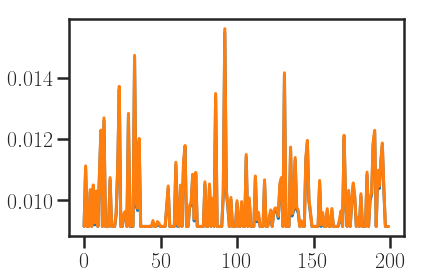

In [32]:
plt.plot(np.exp(u_pgd))
plt.plot(u_sink_like)
# plt.plot(np.log(u_green_like))

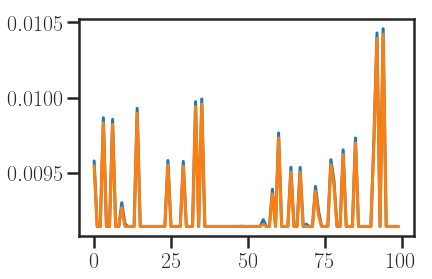

In [33]:
plt.plot(np.exp(v_pgd))
plt.plot(v_sink_like); 

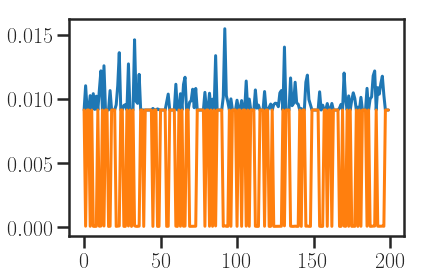

In [34]:
plt.plot(np.exp(u_pgd))
plt.plot(u_green_like);

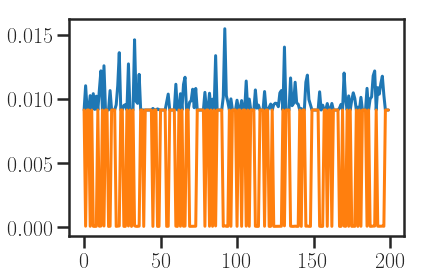

In [35]:
plt.plot(np.exp(u_pgd))
plt.plot(u_green_like); 